# Analysis of Oscillations

This is an analysis of a new algorithm for finding parameter values that result in sustained oscillations. The analysis uses the ~30 files with 2-3 floating species.

The section Numerical Evaluations contains 3 plots for each of the ~30 files:
* Simulation of the original parameterization
* Simulation of the parameterization used to initialize the new algorithm (sets all parameters to 1)
* Simulation of the "optimized parameters", those produced by the new algorithm

See the Summary section for a comparison of the algorithms on the 3-state data.

# Preliminaries

## Imports

In [1]:
import tellurium as te
import sympy
import matplotlib.pyplot as plt
import numpy as np
import os

from common_python.sympy import sympyUtil as su
from common_python.ODEModel.ODEModel import ODEModel
from common_python.ODEModel.oscillationFinder import OscillationFinder, XDict
import matplotlib.pyplot as plt

## Constants

In [2]:
su.addSymbols("S0 S1 S2 S3 S4 S5 S6 S7 S8 S9 k0 k1 k2 k3 k4 k5 k6 k7 k8 k9 k10 k11 k12 k13 k14 k15 k16 k17 k18 k19 k20")
su.addSymbols("J0 J1 J2 J3 J4 J5 J6 J7 J8 J9 J10 J11 J12 J13 J14 J15 J16 J`7 J18 J19 J20")
FLUXES = [J0, J1, J2, J3, J4, J5, J6, J7, J8, J9, J10, J11, J12, J13, J14, J15]
SPECIES = [S0, S1, S2, S3, S4, S5, S6, S7, S8]
MODEL_DIR = "/home/ubuntu/ComplexSystems/models/3-state"

In [3]:
MODEL = """
J0: S0 -> S2; k0*S0
J1: S3 + S3 -> S0; k5*S3*S3
J2: S2 -> S3; k6*S2
J3: S3 ->; k9*S2*S3
J4: -> S3; k10*S0
k0 = 6+0.9011095014634776
k5 = 1.4823891153952284
k6 = -10+15.149868787476994
k9 = 91.19197034598812
k10 = 200
S0 = 1.0
S1 = 5.0
S2 = 9.0
S3 = 3.0
S4 = 10.0
"""
RR = te.loada(MODEL)

# Algorithm

Details of the algorithm are in the file ``oscillationFinder.py``, especially the ``find`` method. The key elements are:
* An eigenvalue based criteria for detecting oscillations that uses the distance to the feasibility region (non-negative real part and imaginary part > 1).
* A parameter search that uses a loss function that is the maximum across the eigenvalues of the distance from the feasibility region.
* The search is attempted 3 times.

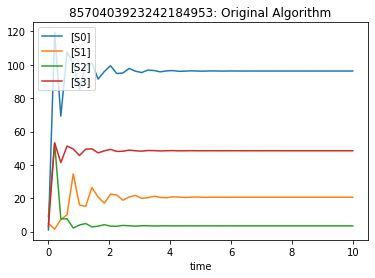

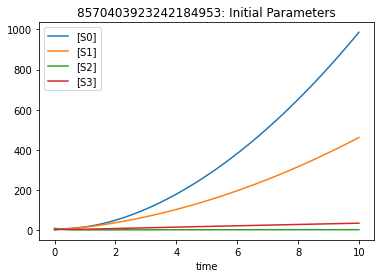

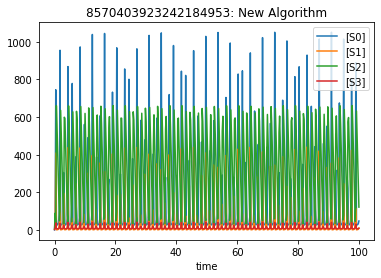

In [4]:
def analyzeFile(path, numRestart=2, isPlot=True, **kwargs):
    """
    Finds parameters with oscillations for a single file.
    Plots simulations for the initial and optimized parameters.
    """
    def mkTitle(string):
        start = path.index("Model_") + len("Model_")
        end = path.index(".ant")
        prefix = path[start:end]
        return "%s: %s" % (prefix, string)
    #
    for idx in range(numRestart + 1):
        rr = te.loada(path)
        finder = OscillationFinder(rr)
        if idx == 0:
            # Plot simulation of the original parameters
            finder.simulate()
            finder.plot(title=mkTitle("Original Algorithm"), isPlot=isPlot)
            # Change the parameter values
            initialParameterXD = XDict.mkParameters(rr)
            initialParameterXD = XDict(initialParameterXD.keys(), 1)
            # finder.setParameters(initialParameterXD)
            finder.simulate(parameterXD=initialParameterXD)
            finder.plot(title=mkTitle("Initial Parameters"), isPlot=isPlot)
        # Find the parameters
        feasibleParameterXD = finder.find()
        if feasibleParameterXD is not None:
            break
    if feasibleParameterXD is not None:
        finder.simulate(parameterXD=feasibleParameterXD, endTime=100)
        finder.plot(title=mkTitle("New Algorithm"), isPlot=isPlot, **kwargs)
    else:
        print(mkTitle("No feasible parameters found!"))
    return feasibleParameterXD
    

# Tests
ffile = "/home/ubuntu/ComplexSystems/models/3-state/Model_8570403923242184953.ant"
parameterDct = analyzeFile(ffile, isPlot=False)
assert(isinstance(parameterDct, dict))

# Evaluations of 3-state Files

Analyzes the eigenvalues numerically for the antimony simulation model

In [5]:
files = [os.path.join(MODEL_DIR, f) for f in os.listdir(MODEL_DIR) if os.path.isfile(os.path.join(MODEL_DIR, f))]
files

['/home/ubuntu/ComplexSystems/models/3-state/Model_8570403923242184953.ant',
 '/home/ubuntu/ComplexSystems/models/3-state/Model_308756242966137270.ant',
 '/home/ubuntu/ComplexSystems/models/3-state/Model_1179159900924707683.ant',
 '/home/ubuntu/ComplexSystems/models/3-state/Model_495895561502583999.ant',
 '/home/ubuntu/ComplexSystems/models/3-state/Model_504265579707051998.ant',
 '/home/ubuntu/ComplexSystems/models/3-state/Model_7767344276012911592.ant',
 '/home/ubuntu/ComplexSystems/models/3-state/Model_191588763966222966.ant',
 '/home/ubuntu/ComplexSystems/models/3-state/Model_5596570675878850909.ant',
 '/home/ubuntu/ComplexSystems/models/3-state/Model_8734971625908708850.ant',
 '/home/ubuntu/ComplexSystems/models/3-state/Model_2039186835123380747.ant',
 '/home/ubuntu/ComplexSystems/models/3-state/Model_118483669170045219.ant',
 '/home/ubuntu/ComplexSystems/models/3-state/Model_6648256619537599386.ant',
 '/home/ubuntu/ComplexSystems/models/3-state/Model_5692220670942502751.ant',
 '/h

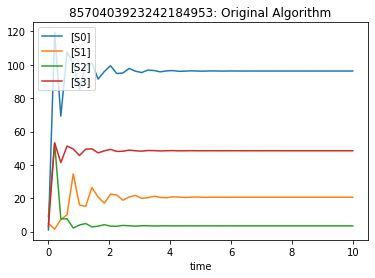

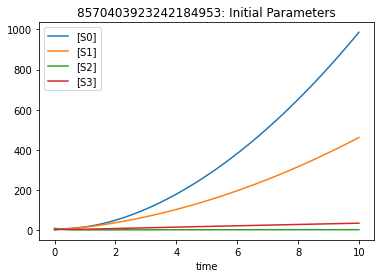

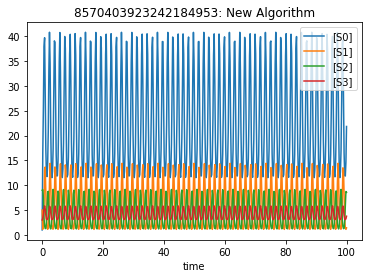

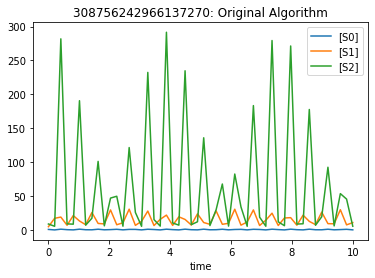

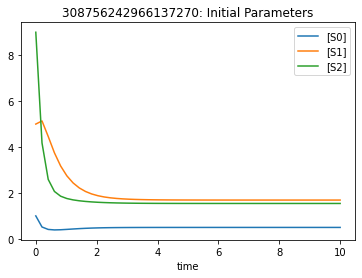

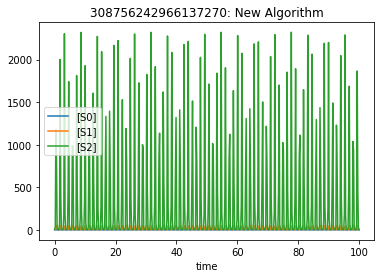

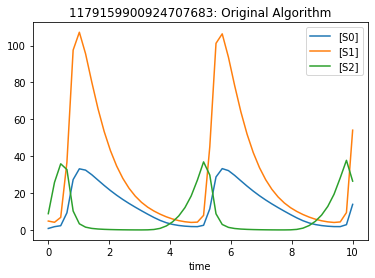

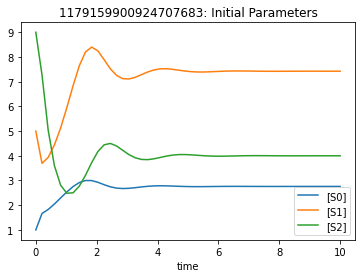

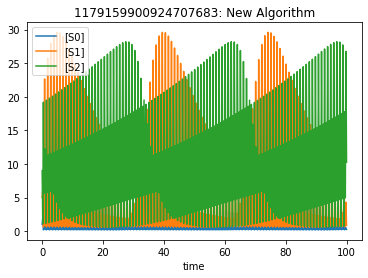

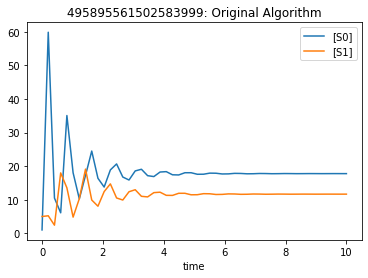

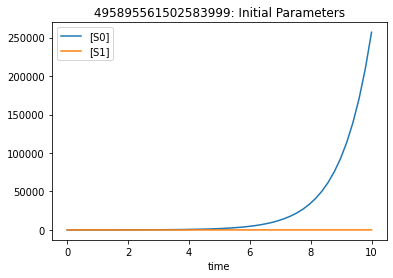

In [ ]:
for ffile in files:
    analyzeFile(ffile)

# Summary

The original algorithm reports either sustained or dampled oscillations. The new algorithm reports either sustained oscillations or no oscillation. There is one case in which the new algorithm reports a sustained oscillation that is not evident in the plot (2965*), but repeating the search does find sustained oscillations.

Here's a summary:
* Old/Sustained, New/Sustained: 24
* Old/Damped, New/Sustained: 7
* Old/Damped, New/No sustained: 2

In [ ]:
# Failed to detect a sustained oscillation
negFiles = [
      "/home/ubuntu/ComplexSystems/models/3-state/Model_495895561502583999.ant",
      "/home/ubuntu/ComplexSystems/models/3-state/Model_3704614159356947411.ant",
]

# Detected a sustained oscillation, but plot doesn't show an isolation
missedPosFiles = [
    "/home/ubuntu/ComplexSystems/models/3-state/Model_6136176155644140162.ant",
]

# Failed detection of new algorithm
failedFiles = [
    "/home/ubuntu/ComplexSystems/models/3-state/Model_2968569378260811723.ant",
]

parameterXD = analyzeFile(failedFiles[0])